# PINN for modelling acetate overflow in E. coli

This notebook presents the jinns final workflow for modelling P. Millard et al. (2020) data for acetate overflow in E. coli. 

In [1]:
#Imports
import pandas as pd
import jax
import numpy as np
import jax.numpy as jnp
import optax
import PINN_model as pm
import Utils,Millard_ODE_functions

In [2]:
#DataGeneratorParams – Parameters set for DataGeneratorODE of jinns

nt = int(2**12) #number of total time points that will be divided into n batches
batch_size = 61 #61  #size of the batches. Here, small batches
method = "uniform" #method used by the DataGenerator for sampling the batches
tmin = 0.0    #min value of the time domain to consider
tmax = 4.25    #max value of the time domain to consider
Tmax = 1.0   #unclear (does nothing at the moment)
n = 61 #61   #number of time points of the data?
DataGeneratorParams=[nt,batch_size,method,tmin,tmax,Tmax,n]

In [3]:
#NNStructure – Structure of the network
import equinox as eqx
#Using Utils.Linear because of issues with the bias using equinox.Linear – the function is the same
nb_hidden_layers=6                                               #6 hidden layer (from Raissi's code) – 7 in lab's code
n_neu=50                                                          #layers of 40 neurons (Raissi) – 20 in lab's code
layers = [(eqx.nn.Linear,1, n_neu), (jax.nn.leaky_relu,)]          # Activation function : jax.nn.leaky_relu
for _ in range(nb_hidden_layers):
    layers.append((eqx.nn.Linear,n_neu, n_neu))
    layers.append((jax.nn.leaky_relu,))                           #Activation function to be checked from Raissi's code – it's sigmoid and not leaky_relu (but sigmoid doesn't actually work)
layers.append((eqx.nn.Linear,n_neu, 6))                            #output_size=number of variables=6 (because a network per variable)
#layers.append((jnp.exp,))
layers=tuple(layers)

layers_params=n_neu+n_neu*nb_hidden_layers+n_neu

In [4]:
#Paramètres
def crea_init(targetting,ODEParams):
    initialisation=[]
    for v in range(len(ODEParams["true_values"])):
        if targetting[v]:
            initialisation.append(float(10**(len(str(floor(ODEParams["true_values"][v])))-1)))
        else:
            initialisation.append(ODEParams["true_values"][v])
    return np.array(initialisation)

from math import floor
ODEParams=pd.DataFrame({
        "names": np.array(['v_max_glycolysis', 'Km_GLC', 'Ki_ACE_glycolysis', 'volume', 'v_feed', 'D', 'v_max_acetate_exchange', 'Keq_acetate_exchange', 'Km_ACE_acetate_exchange', 'Y', 'v_max_TCA_cycle', 'Km_ACCOA_TCA_cycle', 'Ki_ACE_TCA_cycle', 'v_max_Pta', 'Keq_Pta', 'Km_ACP_Pta', 'Km_P', 'Km_ACCOA_Pta', 'COA', 'P', 'Ki_P', 'Ki_ACP', 'Km_COA', 'v_max_AckA', 'ADP', 'ATP', 'Keq_AckA', 'Km_ACP_AckA', 'Km_ADP', 'Km_ATP', 'Km_ACE_AckA']),
        "true_values": np.array([5557.64, 0.02, 36.6776, 0.00177, 0.0, 0.0, 480034.5536336427, 1.0, 33.15358053265956, 9.980425734506176e-05, 740859.8734990103, 24.759179607035055, 2.3261654310710522, 9565521.763455136, 0.0281, 0.7, 2.6, 0.2, 1.22, 10.0, 2.6, 0.2, 0.029, 336940.01763224584, 0.606, 2.4, 174.0, 0.16, 0.5, 0.07, 7.0]),
    })

equation=np.array(['14','14','14','12','1','123','26','26','26','3','34','34','34','45','45','45','45','45','45','45','45','45','45','56','56','56','56','56','56','56','56'])
targetting=np.array([False for i in range(31)])
targetting=np.array(['0' in eq for eq in equation])
targetting[4]=False
targetting[5]=False
initialisation=crea_init(targetting,ODEParams) #to get the order of magnitude for each parameters targeted

ODEParams['initialisation']=initialisation
ODEParams['equation']=equation
ODEParams['targetting']=targetting
ODEParams['tracked']=np.array([True for i in range(31)])

In [5]:
#BiologicalModelAndParameters – All the relevant biological information
BioMod=pm.BiologicalModel(
    ODEFunction=Millard_ODE_functions.SBINN_metabo,
    DataFile= 'generated_Millard_data.csv', #'generated_data_reduced.csv', #
    MetabolitesNames=['GLC','ACE_env','X','ACCOA','ACP','ACE_cell'],
    ODEParams=ODEParams,
    init_time=jnp.array(0.),
    init_metabo_conc=jnp.array([12.89999655, 0.9200020244, 0.06999993881, 0.27305, 0.063, 1.035])
    )

In [6]:
pinn_mod=pm.PINN_model(2, 'generated_Millard_data.csv', DataGeneratorParams, layers, layers_params, BioMod)

In [23]:
#TrainingProcess – determines how the model should be train, with successive steps
TrainingProcess=[
    Utils.IndivTrainingProcess(
        dyn_loss_weight=0.,
        init_cond_weight=1.,#0.05,
        obs_weight=1.,#0.95,
        n_iter=int(1000),
        optimizer=optax.adam(learning_rate=1e-3, b1=0.9, b2=0.8)),
    Utils.IndivTrainingProcess(
        dyn_loss_weight=jnp.array([1e-0, 1e-0, 1e-0, 1e-9, 1e-9, 1e-0]), #jnp.array([1e-2, 1e-1, 1e-2, 1e-10, 1e-2, 1e-8]), #
        init_cond_weight=1000.,
        obs_weight=1000.,
        n_iter=int(15000),
        optimizer=optax.adam(learning_rate=5e-4, b1=0.9, b2=0.8)),
    # Utils.IndivTrainingProcess(
    #     dyn_loss_weight=0.05, #jnp.array([1e-4, 1e-1, 1e-1, 1e-14, 1e-15, 1e-8]), #jnp.array([1e-2, 1e-1, 1e-2, 1e-10, 1e-2, 1e-8]), #
    #     init_cond_weight=0.05,
    #     obs_weight=0.95,
    #     n_iter=int(40000),
    #     optimizer=optax.adam(learning_rate=1e-4, b1=0.9, b2=0.8)),
    # Utils.IndivTrainingProcess(
    #     dyn_loss_weight=0.05, #jnp.array([1e-4, 1e-1, 1e-1, 1e-14, 1e-15, 1e-8]), #jnp.array([1e-2, 1e-1, 1e-2, 1e-10, 1e-2, 1e-8]), #
    #     init_cond_weight=0.05,
    #     obs_weight=0.95,
    #     n_iter=int(20000),
    #     optimizer=optax.adam(learning_rate=1e-5, b1=0.9, b2=0.8))
    ]

In [24]:
#Model training
pinn_mod.train(TrainingProcess, indep_trainings=False, testing_loss_function=True)


Compilation took
 3.676870822906494 

[train] Iteration 0: loss value = 269.56243896484375

Stopping main optimization loop, cause: max iteration is reached

Training took
 0.7632465362548828 


Final iteration 1000: train loss value = 0.005052258260548115

Compilation took
 6.815128326416016 

[train] Iteration 0: loss value = 3391.56640625
[train] Iteration 1000: loss value = 572.955322265625
[train] Iteration 2000: loss value = 1383.4041748046875
[train] Iteration 3000: loss value = 1505.9920654296875
[train] Iteration 4000: loss value = 327.72174072265625
[train] Iteration 5000: loss value = 646.2093505859375
[train] Iteration 6000: loss value = 296.5313415527344
[train] Iteration 7000: loss value = 716.31298828125
[train] Iteration 8000: loss value = 538.8572998046875
[train] Iteration 9000: loss value = 624.9156494140625
[train] Iteration 10000: loss value = 487.62884521484375
[train] Iteration 11000: loss value = 363.03173828125
[train] Iteration 12000: loss value = 273.2165222

In [25]:
pinn_mod.process_memory[-1][2]

{'dyn_loss': Array([ 3388.0842 , 27782.658  ,  1440.793  , ...,   484.32556,
          151.8611 ,   403.292  ], dtype=float32),
 'initial_condition': Array([0.24350813, 1.1355664 , 0.17774475, ..., 0.21143055, 1.7572045 ,
        0.45195517], dtype=float32),
 'observations': Array([ 3.2387352, 14.878222 , 16.781792 , ..., 32.084644 , 37.535103 ,
        46.69474  ], dtype=float32)}

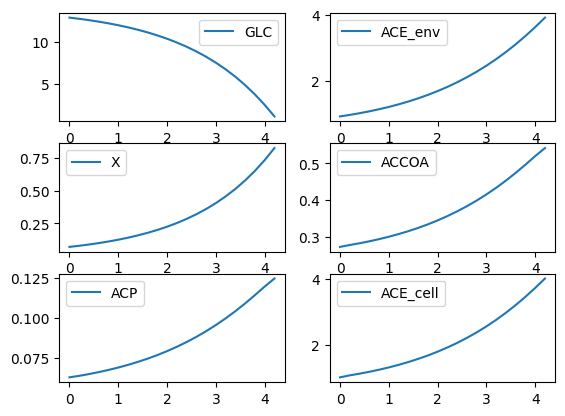

In [21]:
#ValidationSet – Scipy's ODE solving with the right parameters (i.e. true values)

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def acetate_overflow_model(
    t,
    v_max_glycolysis=5557.64,
    Km_GLC=0.02,
    Ki_ACE_glycolysis=36.6776,
    volume=0.00177,
    v_feed=0,
    D=0,
    v_max_acetate_exchange=480034.55363364267,
    Keq_acetate_exchange=1,
    Km_ACE_acetate_exchange=33.153580532659561,
    Y=9.980425734506176e-05,
    v_max_TCA_cycle=740859.87349901034,
    Km_ACCOA_TCA_cycle=24.759179607035055,
    Ki_ACE_TCA_cycle=2.3261654310710522,
    v_max_Pta=9565521.7634551357,
    Keq_Pta=0.0281,
    Km_ACP_Pta=0.7,
    Km_P=2.6,
    Km_ACCOA_Pta=0.2,
    COA=1.22,
    P=10,
    Ki_P=2.6,
    Ki_ACP=0.2,
    Km_COA=0.029,
    v_max_AckA=336940.01763224584,
    ADP=0.606,
    ATP=2.4,
    Keq_AckA=174,
    Km_ACP_AckA=0.16,
    Km_ADP=0.5,
    Km_ATP=0.07,
    Km_ACE_AckA=7,
):
    def func(y, t):

        GLC, ACE_env, X, ACCOA, ACP, ACE_cell = [y[i] for i in range(len(y))]

        r1 = lambda V, S, Km, I, Ki : V*S/((Km+S)*(1+I/Ki))

        v_glycolysis = lambda v_max_glycolysis, GLC, Km_GLC, ACE_env, Ki_ACE_glycolysis : r1(v_max_glycolysis, GLC, Km_GLC, ACE_env, Ki_ACE_glycolysis)

        v_TCA_cycle = lambda v_max_TCA_cycle, ACCOA, Km_ACCOA_TCA_cycle, ACE_env, Ki_ACE_TCA_cycle : r1(v_max_TCA_cycle, ACCOA, Km_ACCOA_TCA_cycle, ACE_env, Ki_ACE_TCA_cycle)

        v_AckA = lambda v_max_AckA, ACP, ADP, ACE_cell, ATP, Keq_AckA, Km_ACP_AckA, Km_ADP, Km_ATP, Km_ACE_AckA : \
           v_max_AckA*(ACP*ADP-ACE_cell*ATP/Keq_AckA)/(Km_ACP_AckA*Km_ADP)/((1+ACP/Km_ACP_AckA+ACE_cell/Km_ACE_AckA)*(1+ADP/Km_ADP+ATP/Km_ATP))

        v_Pta = lambda v_max_Pta, ACCOA, P, ACP, COA, Keq_Pta, Km_ACP_Pta, Km_P, Km_ACCOA_Pta, Ki_P, Ki_ACP, Km_COA : \
           v_max_Pta*(ACCOA*P-ACP*COA/Keq_Pta)/(Km_ACCOA_Pta*Km_P)/(1+ACCOA/Km_ACCOA_Pta+P/Ki_P+ACP/Ki_ACP+COA/Km_COA+ACCOA*P/(Km_ACCOA_Pta*Km_P)+ACP*COA/(Km_ACP_Pta*Km_COA))

        v_acetate_exchange = lambda v_max_acetate_exchange, ACE_cell, ACE_env, Keq_acetate_exchange, Km_ACE_acetate_exchange : \
           v_max_acetate_exchange*(ACE_cell-ACE_env/Keq_acetate_exchange)/Km_ACE_acetate_exchange/(1+ACE_cell/Km_ACE_acetate_exchange+ACE_env/Km_ACE_acetate_exchange)

        dGLCdt = - v_glycolysis(v_max_glycolysis=v_max_glycolysis,
                            GLC=GLC,
                            Km_GLC=Km_GLC,
                            ACE_env=ACE_env,
                            Ki_ACE_glycolysis=Ki_ACE_glycolysis) \
               *X \
               *(volume) \
               +(v_feed-D*GLC)

        dACE_envdt = v_acetate_exchange(v_max_acetate_exchange=v_max_acetate_exchange,
                                    ACE_cell=ACE_cell,
                                    ACE_env=ACE_env,
                                    Keq_acetate_exchange=Keq_acetate_exchange,
                                    Km_ACE_acetate_exchange=Km_ACE_acetate_exchange) \
               *X \
               *(volume) \
               +(-D*ACE_env)

        dXdt = X \
            *v_TCA_cycle(v_max_TCA_cycle=v_max_TCA_cycle,
                         ACCOA=ACCOA,
                         Km_ACCOA_TCA_cycle=Km_ACCOA_TCA_cycle,
                         ACE_env=ACE_env,
                         Ki_ACE_TCA_cycle=Ki_ACE_TCA_cycle) \
            *Y \
            +(-D*X)

        dACCOAdt = 1.4*v_glycolysis(v_max_glycolysis=v_max_glycolysis,
                                GLC=GLC,
                                Km_GLC=Km_GLC,
                                ACE_env=ACE_env,
                                Ki_ACE_glycolysis=Ki_ACE_glycolysis) \
            - v_Pta(v_max_Pta=v_max_Pta,
                    ACCOA=ACCOA,
                    P=P,
                    ACP=ACP,
                    COA=COA,
                    Keq_Pta=Keq_Pta,
                    Km_ACP_Pta=Km_ACP_Pta,
                    Km_P=Km_P,
                    Km_ACCOA_Pta=Km_ACCOA_Pta,
                    Ki_P=Ki_P,
                    Ki_ACP=Ki_ACP,
                    Km_COA=Km_COA) \
            - v_TCA_cycle(v_max_TCA_cycle=v_max_TCA_cycle,
                          ACCOA=ACCOA,
                          Km_ACCOA_TCA_cycle=Km_ACCOA_TCA_cycle,
                          ACE_env=ACE_env,
                          Ki_ACE_TCA_cycle=Ki_ACE_TCA_cycle)

        dACPdt = v_Pta(v_max_Pta=v_max_Pta,
                   ACCOA=ACCOA,
                   P=P,
                   ACP=ACP,
                   COA=COA,
                   Keq_Pta=Keq_Pta,
                   Km_ACP_Pta=Km_ACP_Pta,
                   Km_P=Km_P,
                   Km_ACCOA_Pta=Km_ACCOA_Pta,
                   Ki_P=Ki_P,
                   Ki_ACP=Ki_ACP,
                   Km_COA=Km_COA) \
            - v_AckA(v_max_AckA=v_max_AckA,
                     ACP=ACP,
                     ADP=ADP,
                     ACE_cell=ACE_cell,
                     ATP=ATP,
                     Keq_AckA=Keq_AckA,
                     Km_ACP_AckA=Km_ACP_AckA,
                     Km_ADP=Km_ADP,
                     Km_ATP=Km_ATP,
                     Km_ACE_AckA=Km_ACE_AckA)

        dACE_celldt = v_AckA(v_max_AckA=v_max_AckA,
                         ACP=ACP,
                         ADP=ADP,
                         ACE_cell=ACE_cell,
                         ATP=ATP,
                         Keq_AckA=Keq_AckA,
                         Km_ACP_AckA=Km_ACP_AckA,
                         Km_ADP=Km_ADP,
                         Km_ATP=Km_ATP,
                         Km_ACE_AckA=Km_ACE_AckA) \
                  - v_acetate_exchange(v_max_acetate_exchange=v_max_acetate_exchange,
                                       ACE_cell=ACE_cell,
                                       ACE_env=ACE_env,
                                       Keq_acetate_exchange=Keq_acetate_exchange,
                                       Km_ACE_acetate_exchange=Km_ACE_acetate_exchange)
        return np.array([dGLCdt, dACE_envdt, dXdt, dACCOAdt, dACPdt, dACE_celldt])

    y0 = [12.89999655, 0.9200020244, 0.06999993881, 0.27305, 0.063, 1.035]
    return odeint(func, y0, t)

t = np.arange(0, 4.25, 0.2)[:, None] / Tmax
y = acetate_overflow_model(np.ravel(t))

fig, axes = plt.subplots(3, 2)
labels = ["GLC", "ACE_env", "X", "ACCOA", "ACP", "ACE_cell"]
for i in range(3):
    for j in range(2):
        idx = jnp.ravel_multi_index((i, j), (3, 2))
        axes[i, j].plot(t * Tmax, y[:, idx], label=labels[idx])
        axes[i, j].legend()

Vset=pm.ValidationSet(t,y)

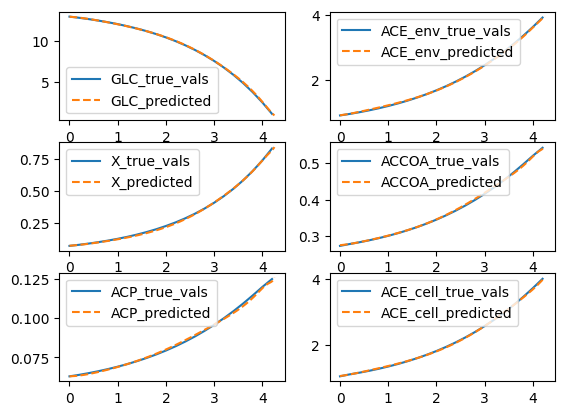

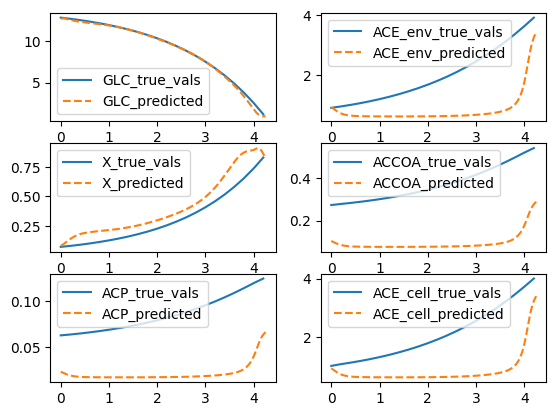

In [22]:
#Plotting the results
for k in range(len(TrainingProcess)):
    pinn_mod.integration_plotting(step=k, ValidationSet=Vset)

In [12]:
#Getting the results
R2_vals=pd.DataFrame({'metabolite':np.array(['GLC','ACE_env','X','ACCOA','ACP','ACE_cell'])})
for k in range(len(TrainingProcess)):
  R2_vals['training_R2_model'+str(k)],R2_vals['validation_R2_model'+str(k)]=pinn_mod.integration_results(step=k,ValidationSet=Vset)
print(R2_vals["validation_R2_model3"])

KeyError: 'validation_R2_model3'